In [1]:
import sys
sys.dont_write_bytecode = True

import os

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from _lib import knn, write_lance, _get_nyt_vectors

import numpy as np
import tempfile
import random
import lance
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [15]:
def run_test(
    data,
    query,
    metric,
    num_partitions=256,
    num_sub_vectors=8,
    nprobes_list=[1, 2, 5, 10, 16],
    refine_factor_list=[1, 2, 5, 10, 20],
):
    in_sample = data[random.sample(range(data.shape[0]), 1000), :]
    # ground truth
    print("generating gt")

    gt = knn(query, data, metric, 10)
    gt_in_sample = knn(in_sample, data, metric, 10)

    print("generated gt")
    
    with tempfile.TemporaryDirectory() as d:
        write_lance(d, data)
        ds = lance.dataset(d)

        for q, target in zip(tqdm(in_sample, desc="checking brute force"), gt_in_sample):
            res = ds.to_table(nearest={
                "column": "vec",
                "q": q,
                "k": 10,
                "metric": metric,
            }, columns=["id"])
            assert len(np.intersect1d(res["id"].to_numpy(), target)) == 10
    
        ds = ds.create_index("vec", "IVF_PQ", metric=metric, num_partitions=num_partitions, num_sub_vectors=num_sub_vectors)
    
        recall_data = []
        for nprobes in nprobes_list:
            for refine_factor in refine_factor_list:
                hits = 0
                # check that brute force impl is correct
                for q, target in zip(tqdm(query, desc=f"out of sample, nprobes={nprobes}, refine={refine_factor}"), gt):
                    res = ds.to_table(nearest={
                        "column": "vec",
                        "q": q,
                        "k": 10,
                        "nprobes": nprobes,
                        "refine_factor": refine_factor,
                    }, columns=["id"])["id"].to_numpy()
                    hits += len(np.intersect1d(res, target))
                recall_data.append([
                    "out_of_sample",
                    nprobes,
                    refine_factor,
                    hits / 10 / len(gt),
                ])
                # check that brute force impl is correct
                for q, target in zip(tqdm(in_sample, desc=f"in sample nprobes={nprobes}, refine={refine_factor}"), gt_in_sample):
                    res = ds.to_table(nearest={
                        "column": "vec",
                        "q": q,
                        "k": 10,
                        "nprobes": nprobes,
                        "refine_factor": refine_factor,
                    }, columns=["id"])["id"].to_numpy()
                    hits += len(np.intersect1d(res, target))
                recall_data.append([
                    "in_sample",
                    nprobes,
                    refine_factor,
                    hits / 10 / len(gt_in_sample),
                ])
    return recall_data

In [16]:
def make_plot(recall_data):
    df = pd.DataFrame(recall_data, columns=["case", "nprobes", "refine_factor", "recall"])
    
    num_cases = len(df["case"].unique())
    (fig, axs) = plt.subplots(1, 2, figsize=(16, 8))
    
    for case, ax in zip(df["case"].unique(), axs):
        current_case = df[df["case"] == case]
        sns.heatmap(
            current_case.drop(columns=["case"]).set_index(["nprobes", "refine_factor"])["recall"].unstack(),
            annot=True,
            ax=ax,
        ).set(title=f"Recall -- {case}")

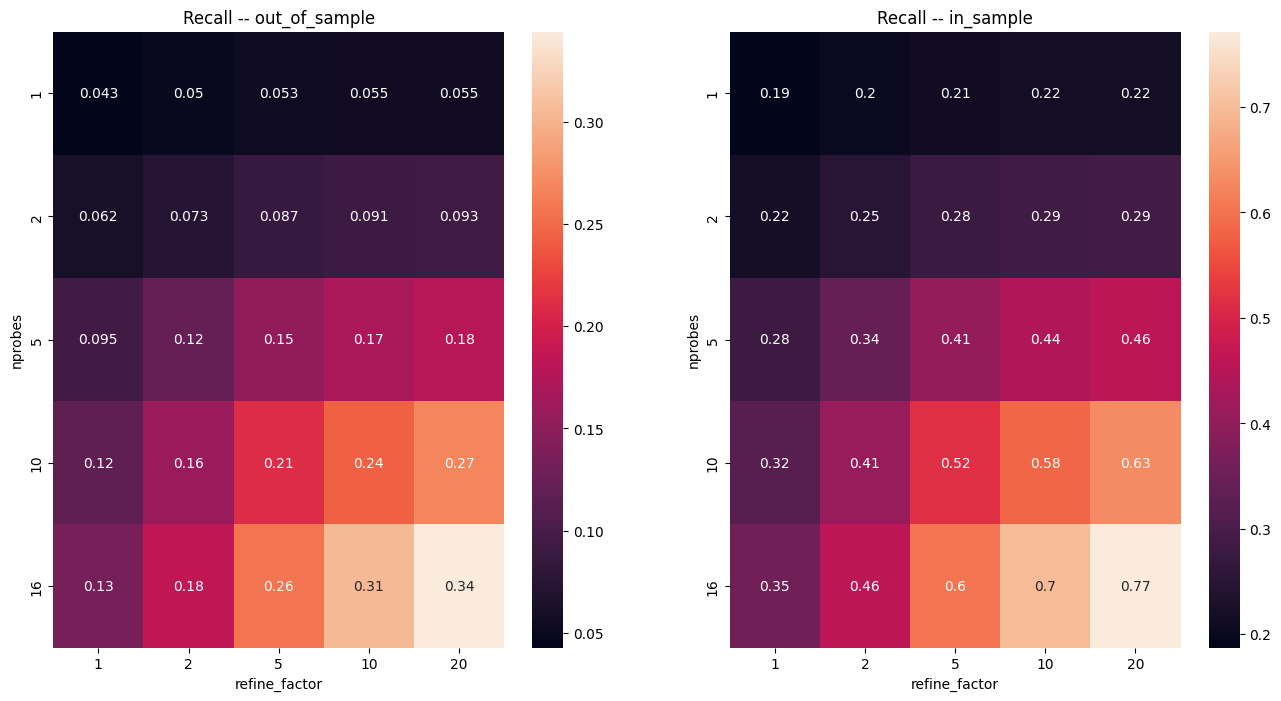

In [19]:
# test randomly generated data
data = np.random.standard_normal((100000, 64))
query = np.random.standard_normal((1000, 64))

recall_data = run_test(
    data,
    query,
    "L2",
)

make_plot(recall_data)

generating gt
generated gt


checking brute force:   0%|          | 0/1000 [00:00<?, ?it/s]

[2024-03-01T06:14:10Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 221 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-03-01T06:14:10Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 197 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-03-01T06:14:10Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 104 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.
[2024-03-01T06:14:10Z WARN  lance_linalg::kmeans] KMeans: more than 10% of clusters are empty: 29 of 256.
    Help: this could mean your dataset is too small to have a meaningful index (less than 5000 vectors) or has many duplicate vectors.


out of sample, nprobes=1, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=1, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=1, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=1, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=1, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=1, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=2, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=2, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=2, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=2, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=2, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=5, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=5, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=5, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=5, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=5, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=10, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=10, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=10, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=10, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=10, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=16, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=16, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=16, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=16, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

in sample nprobes=16, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

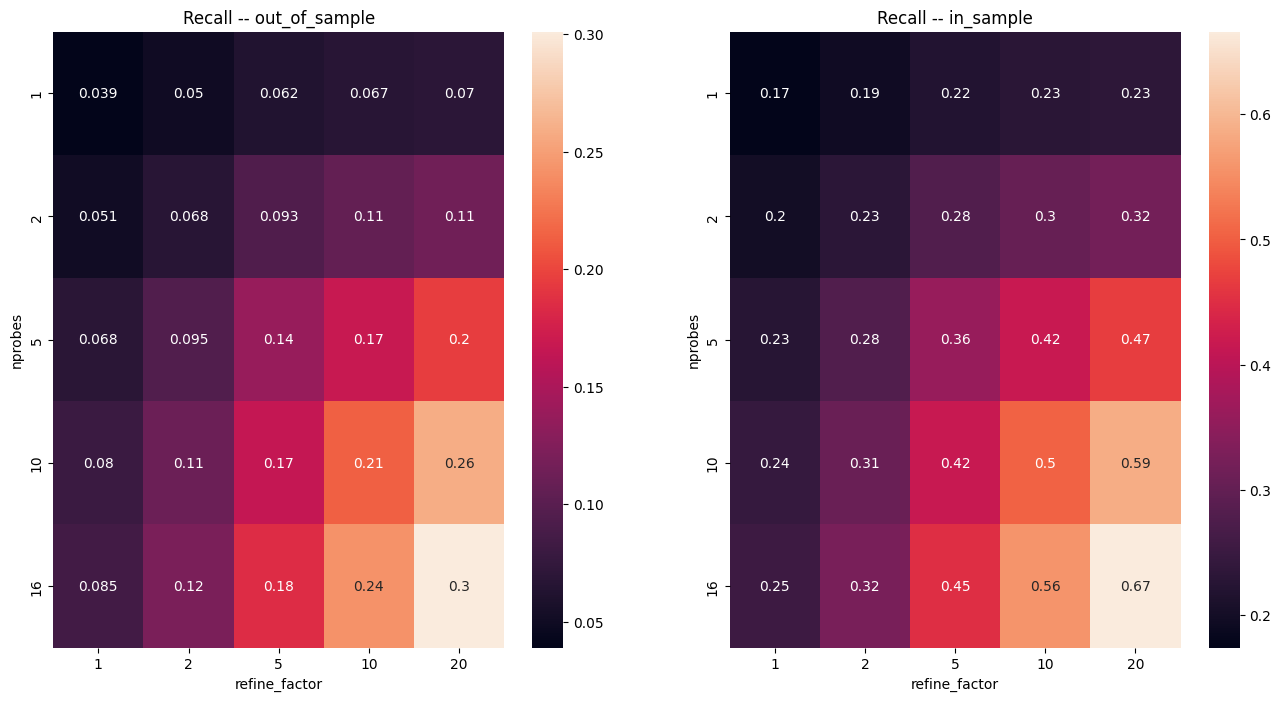

In [22]:
# test randomly generated data -- cosine
data = np.random.standard_normal((100000, 64))
query = np.random.standard_normal((1000, 64))

recall_data = run_test(
    data,
    query,
    "cosine",
)

make_plot(recall_data)

loading from cache
generating gt
generated gt


checking brute force:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

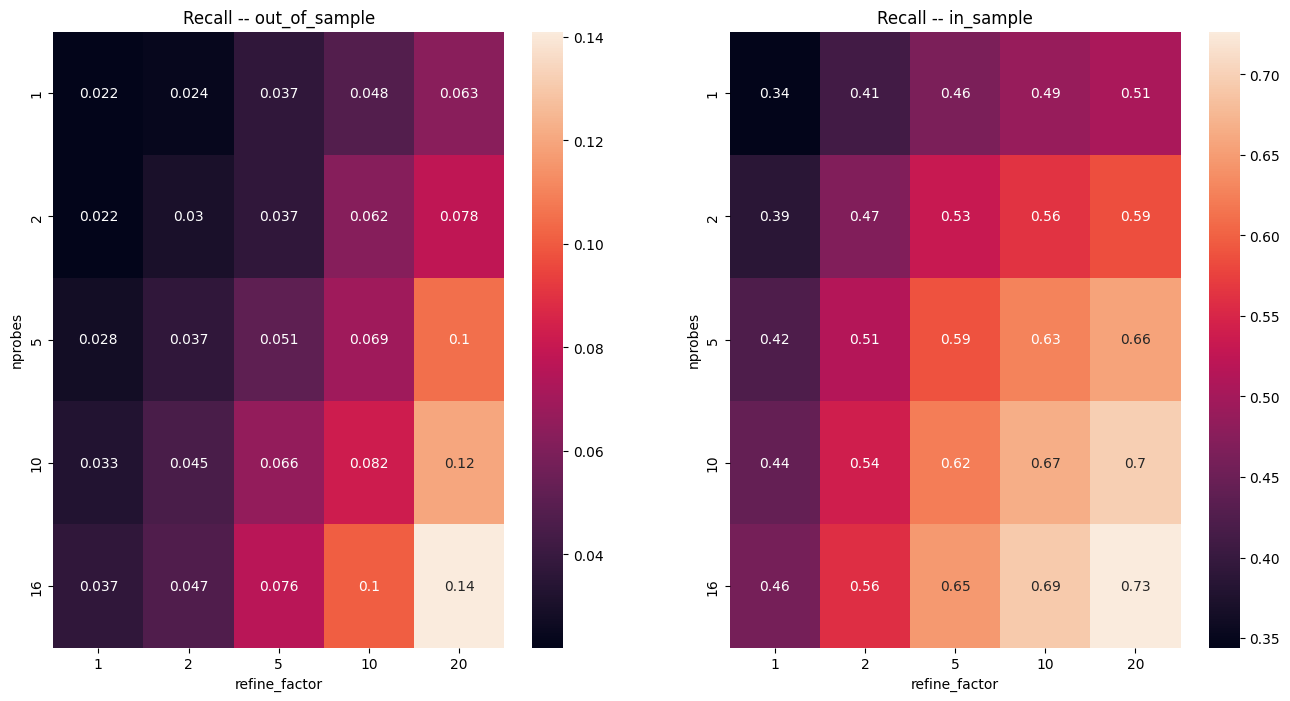

In [22]:
# test NYT -- TF-IDF sparse vectors projected on to 256D dense -- cosine
data = _get_nyt_vectors()
data = data[np.linalg.norm(data, axis=1) != 0]
data = np.unique(data, axis=0)
query = np.random.standard_normal((100, 256))

recall_data = run_test(
    data,
    query,
    "cosine",
    num_partitions=256,
    num_sub_vectors=32,
)

make_plot(recall_data)

loading from cache
generating gt
generated gt


checking brute force:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=1, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=1, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=2, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=2, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=5, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=5, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=10, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=10, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=1:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=1:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=2:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=2:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=5:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=5:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=10:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=10:   0%|          | 0/1000 [00:00<?, ?it/s]

out of sample, nprobes=16, refine=20:   0%|          | 0/100 [00:00<?, ?it/s]

in sample nprobes=16, refine=20:   0%|          | 0/1000 [00:00<?, ?it/s]

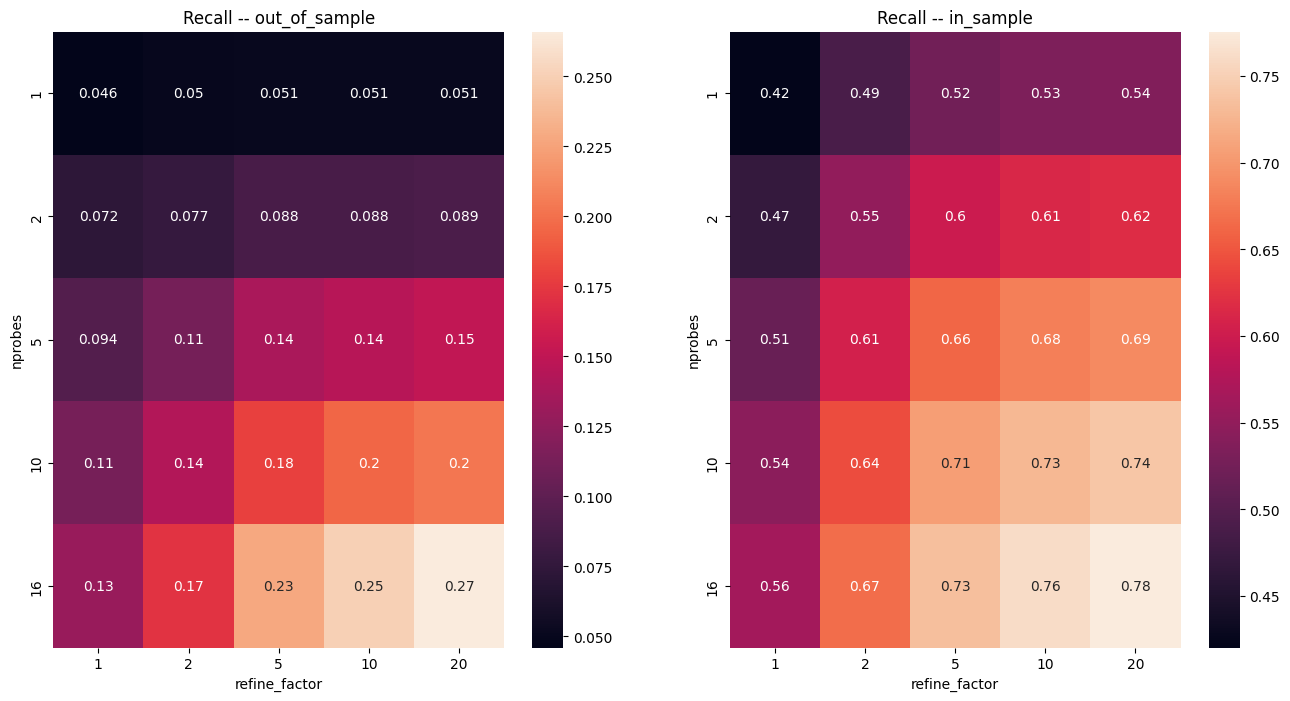

In [19]:
# test NYT -- TF-IDF sparse vectors projected on to 256D dense -- normlized L2
data = _get_nyt_vectors()
data = data[np.linalg.norm(data, axis=1) != 0]
data = np.unique(data, axis=0)
data /= np.linalg.norm(data, axis=1)[:, None]

# use the same out of sample query


recall_data = run_test(
    data,
    query,
    "L2",
    num_partitions=512,
    num_sub_vectors=32,
)

make_plot(recall_data)